# Multivariate Probabilistic Time Series Forecasting with Informer

## Introduction

A few months ago we introduced the [Time Series Transformer](https://huggingface.co/blog/time-series-transformers), which is the vanilla Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)) applied to forecasting, and showed an example for the **univariate** probabilistic forecasting task (i.e. predicting each time series' 1-d distribution individually). In this post we introduce the _Informer_ model ([Zhou, Haoyi, et al., 2021](https://arxiv.org/abs/2012.07436)), AAAI21 best paper which is [now available](https://huggingface.co/docs/transformers/main/en/model_doc/informer) in 🤗 Transformers. We will show how to use the Informer model for the **multivariate** probabilistic forecasting task, i.e., predicting the distribution of a future **vector** of time-series target values. Note that this will also work for the vanilla Time Series Transformer model.

##  Multivariate Probabilistic Time Series Forecasting

As far as the modeling aspect of probabilistic forecasting is concerned, the Transformer/Informer will require no change when dealing with multivariate time series. In both the univariate and multivariate setting, the model will receive a sequence of vectors and thus the only change is on the output or emission side.

Modeling the full joint conditional distribution of high dimensional data can get computationally expensive and thus methods resort to some approximation of the distribution, the easiest being to model the data as an independent distribution from the same family, or some low-rank approximation to the full covariance, etc. Here we will just resort to the independent (or diagonal) emissions which are supported for the families of distributions we have implemented [here](https://huggingface.co/docs/transformers/main/en/internal/time_series_utils).

## Informer - Under The Hood

Based on the vanilla Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), Informer employs two major improvements. To understand these improvements, let's recall the drawbacks of the vanilla Transformer:

1. **Quadratic computation of canonical self-attention:** The vanilla Transformer has a computational complexity of $O(T^2 D)$ where $T$ is the time series length and $D$ is the dimension of the hidden states. For long sequence time-series forecasting (also known as the _LSTF problem_), this might be really computationally expensive. To solve this problem, Informer employs a new self-attention mechanism called _ProbSparse_ attention, which has $O(T \log T)$ time and space complexity.
1. **Memory bottleneck when stacking layers:** When stacking $N$ encoder/decoder layers, the vanilla Transformer has a memory usage of $O(N T^2)$, which limits the model's capacity for long sequences. Informer uses a _Distilling_ operation, for reducing the input size between layers into its half slice. By doing so, it reduces the whole memory usage to be $O(N\cdot T \log T)$.

As you can see, the motivation for the Informer model is similar to Longformer ([Beltagy et el., 2020](https://arxiv.org/abs/2004.05150)), Sparse Transformer ([Child et al., 2019](https://arxiv.org/abs/1904.10509)) and other NLP papers for reducing the quadratic complexity of the self-attention mechanism **when the input sequence is long**. Now, let's dive into _ProbSparse_ attention and the _Distilling_ operation with code examples.

### ProbSparse Attention

The main idea of ProbSparse is that the canonical self-attention scores form a long-tail distribution, where the "active" queries lie in the "head" scores and "lazy" queries lie in the "tail" area. By "active" query we mean a query $q_i$ such that the dot-product $\langle q_i,k_i \rangle$ **contributes** to the major attention, whereas a "lazy" query forms a dot-product which generates  **trivial** attention. Here, $q_i$ and $k_i$ are the $i$-th rows in $Q$ and $K$ attention matrices respectively.

| ![informer_full_vs_sparse_attention](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/informer/informer_full_vs_sparse_attention.png) |
|:--:|
|  Vanilla self attention vs ProbSparse attention from [Autoformer (Wu, Haixu, et al., 2021)](https://wuhaixu2016.github.io/pdf/NeurIPS2021_Autoformer.pdf) |

Given the idea of "active" and "lazy" queries, the ProbSparse attention selects the "active" queries, and creates a reduced query matrix $Q_{reduced}$ which is used to calculate the attention weights in $O(T \log T)$. Let's see this more in detail with a code example.
    
Recall the canonical self-attention formula:

$$
\textrm{Attention}(Q, K, V) = \textrm{softmax}(\frac{QK^T}{\sqrt{d_k}} )V
$$

Where $Q\in \mathbb{R}^{L_Q \times d}, K\in \mathbb{R}^{L_K \times d}, V\in \mathbb{R}^{L_V \times d}$. Note that in practice, the input length of queries and keys are typically equivalent in the self-attention computation, i.e. $L_Q = L_K = T$ where $T$ is the time series length. Therefore, the $QK^T$ multiplication takes $O(T^2 \cdot d)$ computational complexity. In ProbSparse attention, our goal is to create a new $Q_{reduce}$ matrix and define:

$$
\textrm{ProbSparseAttention}(Q, K, V) = \textrm{softmax}(\frac{Q_{reduce}K^T}{\sqrt{d_k}} )V
$$

where the $Q_{reduce}$ matrix only selects the Top $u$ "active" queries. Here, $u = c \cdot \log L_Q$ and $c$ called the _sampling factor_ hyperparameter for the ProbSparse attention. Since $Q_{reduce}$ selects only the Top $u$ queries, its size is $c\cdot \log L_Q \times d$, so the multiplication $Q_{reduce}K^T$ takes only $O(L_K \log L_Q) = O(T \log T)$.

This is good! But how can we select the $u$ "active" queries to create $Q_{reduce}$? Let's define the _Query Sparsity Measurement_.

#### Query Sparsity Measurement
Query Sparsity Measurement $M(q_i, K)$ is used for selecting the $u$ "active" queries $q_i$ in $Q$ to create $Q_{reduce}$. In theory, the dominant $\langle q_i,k_i \rangle$ pairs encourage the "active" $q_i$'s probability distribution **away** from the uniform distribution as can be seen in the figure below. Hence, the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the actual queries distribution and the uniform distribution is used to define the sparsity measurement.

| ![informer_probsparse](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/informer/informer_probsparse.png) |
|:--:|
| The illustration of ProbSparse Attention from official [repository](https://github.com/zhouhaoyi/Informer2020)|


In practice, the measurement is defined as:

$$
M(q_i, K) = \max_j \frac{q_ik_j^T}{\sqrt{d}}-\frac{1}{L_k} \sum_{j=1}^{L_k}\frac{q_ik_j^T}{\sqrt{d}}
$$


The important thing to understand here is when $M(q_i, K)$ is larger, the query $q_i$ should be in $Q_{reduce}$ and vice versa.

But how can we calculate the term $q_ik_j^T$ in non-quadratic time? Recall that most of the dot-product $\langle q_i,k_i \rangle$ generate either way the trivial attention (i.e. long-tail distribution property), so it is enough to randomly sample a subset of keys from $K$, which will be called `K_sample` in the code.

Now, we are ready to see the code of `probsparse_attention`:
    
```python
from torch import nn
import math


def probsparse_attention(query_states, key_states, value_states, sampling_factor=5):
    """
    Compute the probsparse self-attention.
    Input shape: Batch x Time x Channel

    Note the additional `sampling_factor` input.
    """
    # get input sizes with logs
    L_K = key_states.size(1)
    L_Q = query_states.size(1)
    log_L_K = np.ceil(np.log1p(L_K)).astype("int").item()
    log_L_Q = np.ceil(np.log1p(L_Q)).astype("int").item()

    # calculate a subset of samples to slice from K and create Q_K_sample
    U_part = min(sampling_factor * L_Q * log_L_K, L_K)

    # create Q_K_sample (the q_i * k_j^T term in the sparsity measurement)
    index_sample = torch.randint(0, L_K, (U_part,))
    K_sample = key_states[:, index_sample, :]
    Q_K_sample = torch.bmm(query_states, K_sample.transpose(1, 2))

    # calculate the query sparsity measurement with Q_K_sample
    M = Q_K_sample.max(dim=-1)[0] - torch.div(Q_K_sample.sum(dim=-1), L_K)

    # calculate u to find the Top-u queries under the sparsity measurement
    u = min(sampling_factor * log_L_Q, L_Q)
    M_top = M.topk(u, sorted=False)[1]

    # calculate Q_reduce as query_states[:, M_top]
    dim_for_slice = torch.arange(query_states.size(0)).unsqueeze(-1)
    Q_reduce = query_states[dim_for_slice, M_top]  # size: c*log_L_Q x channel

    # and now, same as the canonical
    d_k = query_states.size(-1)
    attn_scores = torch.bmm(Q_reduce, key_states.transpose(-2, -1))  # Q_reduce x K^T
    attn_scores = attn_scores / math.sqrt(d_k)
    attn_probs = nn.functional.softmax(attn_scores, dim=-1)
    attn_output = torch.bmm(attn_probs, value_states)

    return attn_output, attn_scores
```
Note that in the implementation, $U_{part}$ contain $L_Q$ in the calculation for stability issues (see [this disccusion](https://discuss.huggingface.co/t/probsparse-attention-in-informer/34428) for more information).

We did it! Please be aware that this is only a partial implementation of the `probsparse_attention`, and the full implementation can be found in 🤗 Transformers.

### Distilling

Because of the ProbSparse self-attention, the encoder’s feature map has some redundancy that can be removed. Therefore,
the distilling operation is used to reduce the input size between encoder layers into its half slice, thus in theory removing this redundancy. In practice, Informer's "distilling" operation just adds 1D convolution layers with max pooling between each of the encoder layers. Let $X_n$ be the output of the $n$-th encoder layer, the distilling operation is then defined as:


$$
X_{n+1} = \textrm{MaxPool} ( \textrm{ELU}(\textrm{Conv1d}(X_n))
$$


Let's see this in code:
    
```python
from torch import nn

# ConvLayer is a class with forward pass applying ELU and MaxPool1d
def informer_encoder_forward(x_input, num_encoder_layers=3, distil=True):
    # Initialize the convolution layers
    if distil:
        conv_layers = nn.ModuleList([ConvLayer() for _ in range(num_encoder_layers - 1)])
        conv_layers.append(None)
    else:
        conv_layers = [None] * num_encoder_layers
    
    # Apply conv_layer between each encoder_layer
    for encoder_layer, conv_layer in zip(encoder_layers, conv_layers):
        output = encoder_layer(x_input)
        if conv_layer is not None:
            output = conv_layer(loutput)
    
    return output
```
    
By reducing the input of each layer by two, we get a memory usage of $O(N\cdot T \log T)$ instead of $O(N\cdot T^2)$ where $N$ is the number of encoder/decoder layers. This is what we wanted!
    
The Informer model in [now available](https://huggingface.co/docs/transformers/main/en/model_doc/informer) in the 🤗 Transformers library, and simply called `InformerModel`. In the sections below, we will show how to train this model on a custom multivariate time-series dataset.


## Set-up Environment

First, let's install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate,  🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

As we will show, GluonTS will be used for transforming the data to create features as well as for creating appropriate training, validation and test batches.

In [1]:
%pip install -q transformers datasets evaluate accelerate gluonts ujson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00


We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [2]:
from transformers.utils import send_example_telemetry

send_example_telemetry("multivariate_informer_notebook", framework="pytorch")

## Load Dataset

In this blog post, we'll use the `traffic_hourly` dataset, which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). This dataset contains the San Francisco Traffic dataset used by [Lai et al. (2017)](https://arxiv.org/abs/1703.07015). It contains 862 hourly time series showing the road occupancy rates in the range $[0, 1]$ on the San Francisco Bay area freeways from 2015 to 2016.

This dataset is part of the [Monash Time Series Forecasting](https://forecastingdata.org/) repository, a collection of time series datasets from a number of domains. It can be viewed as the [GLUE benchmark](https://gluebenchmark.com/) of time series forecasting.

In [3]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "traffic_hourly")

Generating train split:   0%|          | 0/862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/862 [00:00<?, ? examples/s]

As can be seen, the dataset contains 3 splits: train, validation and test.

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
})

Each example contains a few keys, of which `start` and `target` are the most important ones. Let us have a look at the first time series in the dataset:

In [5]:
train_example = dataset["train"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The `start` simply indicates the start of the time series (as a datetime), and the `target` contains the actual values of the time series.

The `start` will be useful to add time related features to the time series values, as extra input to the model (such as "month of year"). Since we know the frequency of the data is `hourly`, we know for instance that the second value has the timestamp `2015-01-01 01:00:01`, `2015-01-01 02:00:01`, etc.

In [6]:
print(train_example["start"])
print(len(train_example["target"]))

2015-01-01 00:00:01
17448


The validation set contains the same data as the training set, just for a `prediction_length` longer amount of time. This allows us to validate the model's predictions against the ground truth.

The test set is again one `prediction_length` longer data compared to the validation set (or some multiple of  `prediction_length` longer data compared to the training set for testing on multiple rolling windows).

In [7]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The initial values are exactly the same as the corresponding training example. However, this example has `prediction_length=48` (48 hours, or 2 days) additional values compared to the training example. Let us verify it.

In [8]:
freq = "1H"
prediction_length = 48

assert len(train_example["target"]) + prediction_length == len(
    dataset["validation"][0]["target"]
)

Let's visualize this:

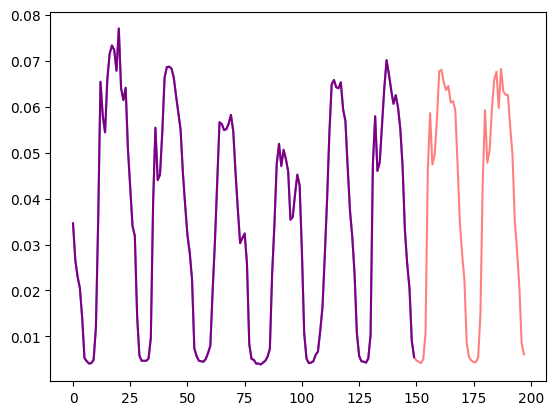

In [9]:
import matplotlib.pyplot as plt

num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    validation_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

Let's split up the data:

In [10]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

## Update `start` to `pd.Period`

The first thing we'll do is convert the `start` feature of each time series to a pandas `Period` index using the data's `freq`:

In [11]:
from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

We now use `datasets`' [`set_transform`](https://huggingface.co/docs/datasets/v2.7.0/en/package_reference/main_classes#datasets.Dataset.set_transform) functionality to do this on-the-fly in place:

In [12]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

Now, let's convert the dataset into a multivariate time series using the `MultivariateGrouper` from GluonTS. This grouper will convert the individual 1-dimensional time series into a single 2D matrix.

In [13]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

Note that now the target is 2 dimensional, where the first dim is the number of variates (number of time-series) and the second is the time-series values (time dimension):

In [18]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(f"multi_variate_train_example[target].shape = {multi_variate_train_example['target'].shape}")

multi_variate_train_example[target].shape = (862, 17448)


## Define the model

Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/main/en/model_doc/informer#transformers.InformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length` (in our case, `48` hours): this is the horizon that the decoder of the Informer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify an efficient "look back" mechanism, where we concatenate values from the past to the current values as additional features, e.g. for a `Daily` frequency we might consider a look back of `[1, 7, 30, ...]` or for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `5` as we'll add `HourOfDay`, `DayOfWeek`, ..., and `Age` features (see below).

Let us check the default lags provided by GluonTS for the given frequency ("hourly"):

In [19]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


This means that this would look back up to 721 hours (~30 days) for each time step, as additional features. However, the resulting feature vector would end up being of size `len(lags_sequence)*num_of_variates` which for our case will be 34480! This is not going to work so we will use our own sensible lags.

Let us also check the default time features which GluonTS provides us:

In [20]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x78a0b33801f0>, <function day_of_week at 0x78a0b3380310>, <function day_of_month at 0x78a0b3380430>, <function day_of_year at 0x78a0b3380550>]


In this case, there are four additional features, namely "hour of day", "day of week", "day of month" and "day of year". This means that for each time step, we'll add these features as a scalar values. For example, consider the timestamp `2015-01-01 01:00:01`. The four additional features will be:

In [21]:
from pandas.core.arrays.period import period_array

timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'hour_of_day': array([-0.45652174]), 'day_of_week': array([0.]), 'day_of_month': array([-0.5]), 'day_of_year': array([-0.5])}


Note that hours and days are encoded as values between `[-0.5, 0.5]` from GluonTS. For more information about `time_features`, please see [this](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/time_feature/_base.py). Besides those 4 features, we'll also add an "age" feature as we'll see later on in the data transformations.

We now have everything to define the model:

In [22]:
from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,

    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

By default, the model uses a diagonal Student-t distribution (but this is [configurable](https://huggingface.co/docs/transformers/main/en/internal/time_series_utils)):

In [23]:
model.config.distribution_output

'student_t'

## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [24]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

The transformations below are annotated with comments, to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [25]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the model due to time- and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:

In [26]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create DataLoaders

Next, it's time to create the DataLoaders, which allow us to have batches of (input, output) pairs - or in other words (`past_values`, `future_values`).

In [27]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [28]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [29]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

Let's check the first batch:

In [30]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 264, 5]) torch.FloatTensor
past_values torch.Size([256, 264, 862]) torch.FloatTensor
past_observed_mask torch.Size([256, 264, 862]) torch.FloatTensor
future_time_features torch.Size([256, 48, 5]) torch.FloatTensor
future_values torch.Size([256, 48, 862]) torch.FloatTensor
future_observed_mask torch.Size([256, 48, 862]) torch.FloatTensor


As can be seen, we don't feed `input_ids` and `attention_mask` to the encoder (as would be the case for NLP models), but rather `past_values`, along with `past_observed_mask`, `past_time_features` and `static_real_features`.

The decoder inputs consist of `future_values`, `future_observed_mask` and `future_time_features`. The `future_values` can be seen as the equivalent of `decoder_input_ids` in NLP.

We refer to the [docs](https://huggingface.co/docs/transformers/main/en/model_doc/informer#transformers.InformerForPrediction.forward.past_values) for a detailed explanation for each of them.

## Forward pass

Let's perform a single forward pass with the batch we just created:

In [31]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [32]:
print("Loss:", outputs.loss.item())

Loss: -1067.3302001953125


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels. The loss is the negative log-likelihood of the predicted distribution with respect to the ground truth values and tends to negative infinity.

Also note that the decoder uses a causal mask to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [33]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 25
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

-1071.0718994140625
-2195.262939453125
-2417.3056640625
-2580.308349609375
-2597.16845703125
-2652.541748046875
-2667.660400390625
-2680.68701171875
-2730.6201171875
-2695.493896484375
-2769.2705078125
-2775.44921875
-2807.027587890625
-2780.075439453125
-2799.7197265625
-2809.899658203125
-2821.509033203125
-2641.331787109375
-2838.125
-2831.751220703125
-2808.112548828125
-2798.142333984375
-2788.380859375
-2848.216064453125
-2846.167236328125


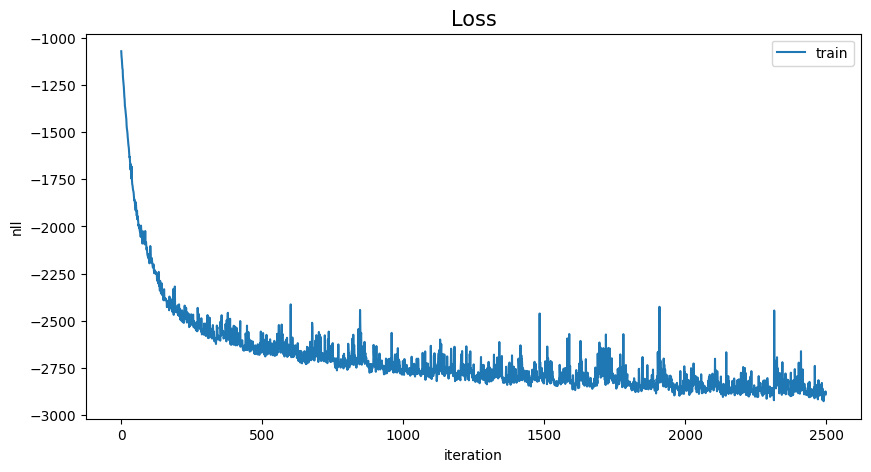

In [34]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [35]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`, `input_size`).

In this case, we get `100` possible values for the next `48` hours for each of the `862` time series (for each example in the batch which is of size `1` since we only have a single multivariate time series):

In [36]:
forecasts_[0].shape

(1, 100, 48, 862)

We'll stack them vertically, to get forecasts for all time-series in the test dataset (just in case there are more time series in the test set):

In [37]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 48, 862)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

We calculate both metrics for each time series variate in the dataset:

In [38]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [39]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.12598923094359


In [40]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.5254409415349527


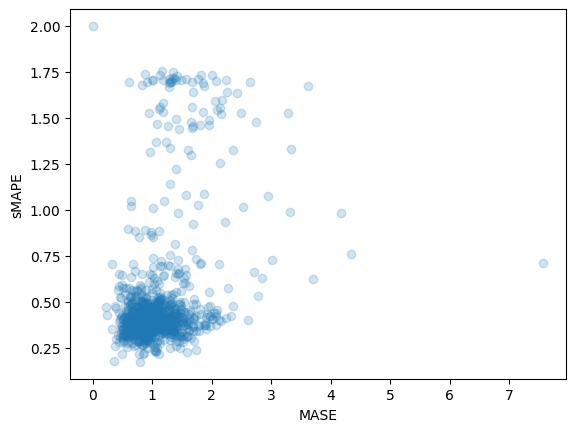

In [41]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

To plot the prediction for any time series variate with respect the ground truth test data we define the following helper:

In [42]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()

For example:

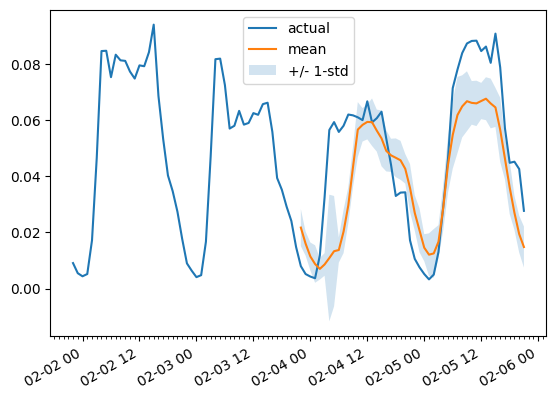

In [43]:
plot(0, 344)

## Conclusion

How do we compare against other models? The [Monash Time Series Repository](https://forecastingdata.org/#results) has a comparison table of test set MASE metrics which we can add to:

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet|  Transformer (uni.) | **Informer (mv. our)**|
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|:--:|
|Traffic Hourly | 1.922	| 1.922	| 2.482 |	2.294|	2.535|	1.281|	1.571	|0.892|	0.825	|1.100|	1.066	| **0.821** | 1.191 |

As can be seen, and perhaps surprising to some, the multivariate forecasts are typically _worse_ than the univariate ones, the reason being the difficulty in estimating the cross-series correlations/relationships. The additional variance added by the estimates often harms the resulting forecasts or the model learns spurious correlations. We refer to [this paper](https://openreview.net/forum?id=GpW327gxLTF) for further reading. Multivariate models tend to work well when trained on a lot of data.

So the vanilla Transformer still performs best here! In the future, we hope to better benchmark these models in a central place to ease reproducing the results of several papers. Stay tuned for more!

## Resources

We recommend to check out the [Informer docs](https://huggingface.co/docs/transformers/main/en/model_doc/informer) and the example notebook linked at the top of this blog post.